# SPR single model predictions

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, average_precision_score, accuracy_score, mean_absolute_error
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
color = sns.color_palette()

Populating the interactive namespace from numpy and matplotlib


In [2]:
from load_data import TARGET_LABELS, load_all_encoded

In [3]:
train_df = load_all_encoded()

In [4]:
train_df.shape

(4250000, 45)

## Try a simple model to predict targets from the current and previous months

Let we have 201503, 201504 as training data and we want to predict on 201505

- Do we need to identify clients ? -> if No => remove 'ncodpers' column => Lose all history information 
    -> if Yes => need to identify the client on the data


Idea 1: 

    a) client's properties -> `TARGET_LABELS` on the current month
    b) For existing clients : client's target_labels of the previous month -> client's target_labels on the current month
    c) For new clients : recommendations ?
        
    
Case a) :

- Remove `ncodpers` from train data 201503, 201504 
- Train `TARGET_LABELS` from other features for 201503, 201504 
- Validate `TARGET_LABELS` for 201505


Case b) :

- Get unique `ncodpers` from test data 201505
- Remove other clients from train data 201502, 201503, 201504 
- Drop non `TARGET_LABELS` features from train data 201502, 201503, 201504 
- Train on `TARGET_LABELS` (or target_value) from 201503 to predict on 201504
- Train on diff of `TARGET_LABELS` (diff of target_value) from 201502, 201503 to predict on 201504
- Validate `TARGET_LABELS` for 201505




In [5]:
train_df['yearmonth'] = train_df['fecha_dato'].apply(lambda x: int(100*x.year + x.month))

In [153]:
drop_cols = ['ncodpers']; drop_cols.extend(TARGET_LABELS)
mask_train = (train_df['yearmonth'] == 201503) | (train_df['yearmonth'] == 201504)
mask_test = train_df['yearmonth'] == 201505

In [154]:
X = train_df[mask_train].drop(drop_cols, axis=1)
Y = train_df[mask_train][TARGET_LABELS]
print X.shape, Y.shape

(500000, 21) (500000, 24)


In [155]:
Z = train_df[mask_test]
ZX = Z.drop(drop_cols, axis=1)
ZY = Z[TARGET_LABELS]

In [156]:
def transform_data(X):
    date_cols = ['fecha_dato', 'fecha_alta']
    out = X.drop(date_cols, axis=1)
    out['duration'] = (X['fecha_dato'] - X['fecha_alta']).dt.days
    cols = out.columns
    out = pd.DataFrame(StandardScaler().fit_transform(out), columns=cols)
    return out

In [157]:
X = transform_data(X)

In [158]:
ZX = transform_data(ZX)

Case "a"

In [159]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)
print X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

(400000, 20) (100000, 20) (400000, 24) (100000, 24)


In [160]:
rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, verbose = 0)

In [161]:
rf.fit(X_train, Y_train)
score = rf.score(X_train, Y_train)
print score

0.9994675


In [162]:
Y_pred = rf.predict(X_test)

In [166]:
print mean_absolute_error(Y_test, Y_pred)
print "Number of wrong predictions : ", (Y_test - Y_pred).sum(1).sum(), " from ", Y_test.shape[0]

0.0480120833333
Number of wrong predictions :  49873.0  from  100000


Feature ranking:
1. feature 19 'duration' (0.302219)
2. feature 17 'logrenta' (0.227699)
3. feature 3 'age' (0.182293)
4. feature 14 'nomprov' (0.084306)
5. feature 12 'canal_entrada' (0.074296)
6. feature 16 'segmento' (0.035586)
7. feature 15 'ind_actividad_cliente' (0.028525)
8. feature 8 'tiprel_1mes' (0.026116)
9. feature 18 'yearmonth' (0.016707)
10. feature 2 'sexo' (0.011906)
11. feature 10 'indext' (0.005071)
12. feature 4 'ind_nuevo' (0.001189)
13. feature 1 'pais_residencia' (0.001039)
14. feature 13 'indfall' (0.000950)
15. feature 0 'ind_empleado' (0.000863)
16. feature 9 'indresi' (0.000571)
17. feature 6 'ult_fec_cli_1t' (0.000323)
18. feature 5 'indrel' (0.000210)
19. feature 11 'conyuemp' (0.000126)
20. feature 7 'indrel_1mes' (0.000005)


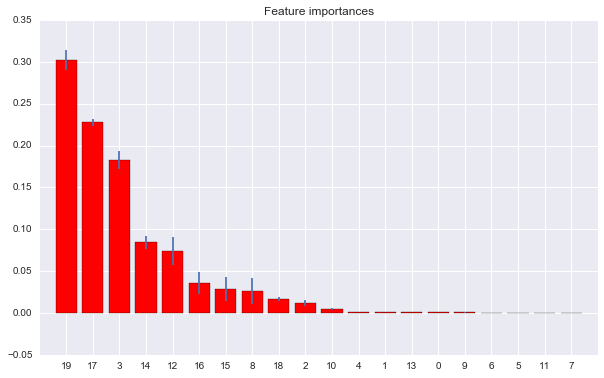

In [24]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
features = X_train.columns.values

for f in range(X.shape[1]):
    print("%d. feature %d '%s' (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [164]:
ZY_pred = rf.predict(ZX)

In [167]:
print mean_absolute_error(ZY, ZY_pred)
print "Number of wrong predictions : ", (ZY - ZY_pred).sum(1).sum(), " from ", ZY.shape[0]

0.036514
Number of wrong predictions :  95324.0  from  250000


Case "b"

Train on `TARGET_LABELS` (or target_value) from 201503 to predict on 201504

No personalization -> very bad results

In [168]:
def dummies_to_decimal(row):
    output = ''
    for v in row.values:
        output += str(int(v))
    return log(int(output,2)+1)

In [169]:
X = train_df[train_df['yearmonth'] == 201503][TARGET_LABELS]
Y = train_df[train_df['yearmonth'] == 201504][TARGET_LABELS]

In [170]:
X.loc[:, 'target_value'] = X.apply(dummies_to_decimal, axis=1)

In [174]:
def transform_data(X):
    cols = X.columns
    out = pd.DataFrame(StandardScaler().fit_transform(X), columns=cols)
    return out

In [175]:
X = transform_data(X)

In [176]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)
print X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

(200000, 25) (50000, 25) (200000, 24) (50000, 24)


In [177]:
rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, verbose = 0)

In [178]:
rf.fit(X_train, Y_train)
score = rf.score(X_train, Y_train)
print score

0.525035


In [179]:
Y_pred = rf.predict(X_test)

In [180]:
print "Number of wrong predictions : ", (Y_test - Y_pred).sum(1).sum(), " from ", Y_test.shape[0]

Number of wrong predictions :  38406.0  from  50000


In [181]:
print mean_absolute_error(Y_test, Y_pred)

0.0516433333333


Work with existing clients

In [183]:
unique_clients = train_df[train_df['yearmonth'] == 201504]['ncodpers'].unique()

In [184]:
common_clients = set(unique_clients)
for y in [201503]:
    old_clients = train_df[train_df['yearmonth'] == y]['ncodpers'].unique()
    common_clients &= set(old_clients)

In [185]:
print len(unique_clients), len(common_clients)

250000 99771


In [186]:
mask_train = (train_df['yearmonth'] == 201504) | (train_df['yearmonth'] == 201503)
df = train_df[mask_train]
df = df[df['ncodpers'].isin(common_clients)]
cols = ['ncodpers', 'yearmonth']; cols.extend(TARGET_LABELS)
df = df[cols]

In [187]:
df.loc[:, 'target_value'] = df[TARGET_LABELS].apply(dummies_to_decimal, axis=1)

In [188]:
df.head()

,ncodpers,yearmonth,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,...,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,target_value
1250000,558662,201503,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,14.556091
1250004,558631,201503,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,14.571595
1250006,558678,201503,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,14.556091
1250008,558730,201503,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0.000000
1250010,558684,201503,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,14.556091


In [189]:
X = df[df['yearmonth'] == 201503]
Y = df[df['yearmonth'] == 201504][TARGET_LABELS]

In [190]:
def transform_data(X):
    date_cols = ['yearmonth', 'ncodpers']
    out = X.drop(date_cols, axis=1)
    cols = out.columns
    out = pd.DataFrame(StandardScaler().fit_transform(out), columns=cols)
    return out

In [191]:
X = transform_data(X)

In [192]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)
print X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

(79816, 25) (19955, 25) (79816, 24) (19955, 24)


In [193]:
rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, verbose = 0)

In [194]:
rf.fit(X_train, Y_train)
score = rf.score(X_train, Y_train)
print score

0.53089606094


In [195]:
Y_pred = rf.predict(X_test)

In [196]:
print "Number of wrong predictions : ", (Y_test - Y_pred).sum(1).sum(), " from ", Y_test.shape[0]

Number of wrong predictions :  15774.0  from  19955


In [197]:
print mean_absolute_error(Y_test, Y_pred)

0.0535413012612


Feature ranking:
1. feature 24 'target_value' (0.339995)
2. feature 7 'ind_ctop_fin_ult1' (0.132382)
3. feature 2 'ind_cco_fin_ult1' (0.050941)
4. feature 17 'ind_reca_fin_ult1' (0.042007)
5. feature 12 'ind_ecue_fin_ult1' (0.041447)
6. feature 18 'ind_tjcr_fin_ult1' (0.040482)
7. feature 23 'ind_recibo_ult1' (0.040092)
8. feature 8 'ind_ctpp_fin_ult1' (0.038817)
9. feature 19 'ind_valo_fin_ult1' (0.038296)
10. feature 11 'ind_dela_fin_ult1' (0.036027)
11. feature 13 'ind_fond_fin_ult1' (0.033966)
12. feature 15 'ind_plan_fin_ult1' (0.029081)
13. feature 14 'ind_hip_fin_ult1' (0.022588)
14. feature 22 'ind_nom_pens_ult1' (0.022310)
15. feature 21 'ind_nomina_ult1' (0.020946)
16. feature 4 'ind_cno_fin_ult1' (0.019816)
17. feature 20 'ind_viv_fin_ult1' (0.016715)
18. feature 6 'ind_ctma_fin_ult1' (0.010269)
19. feature 10 'ind_deme_fin_ult1' (0.008388)
20. feature 16 'ind_pres_fin_ult1' (0.006663)
21. feature 9 'ind_deco_fin_ult1' (0.004510)
22. feature 3 'ind_cder_fin_ult1' (0.002273)


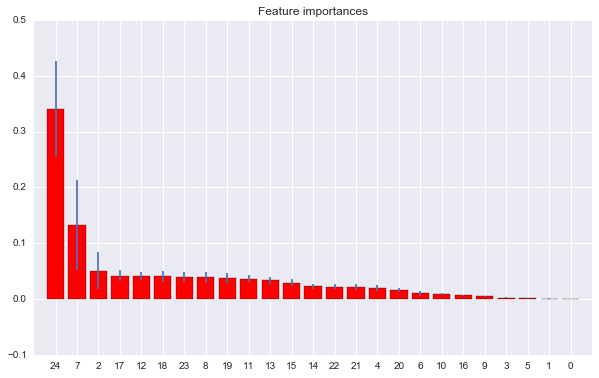

In [142]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
features = X_train.columns.values

for f in range(X.shape[1]):
    print("%d. feature %d '%s' (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()